# Data Exploration

In [1]:
from module.dataset import DATASET_PATH, TRAIN_PATH, TEST_PATH, LABELS_PATH

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from random import choice, sample
import pandas as pd
from PIL import Image
import json

Let's visualize a few images

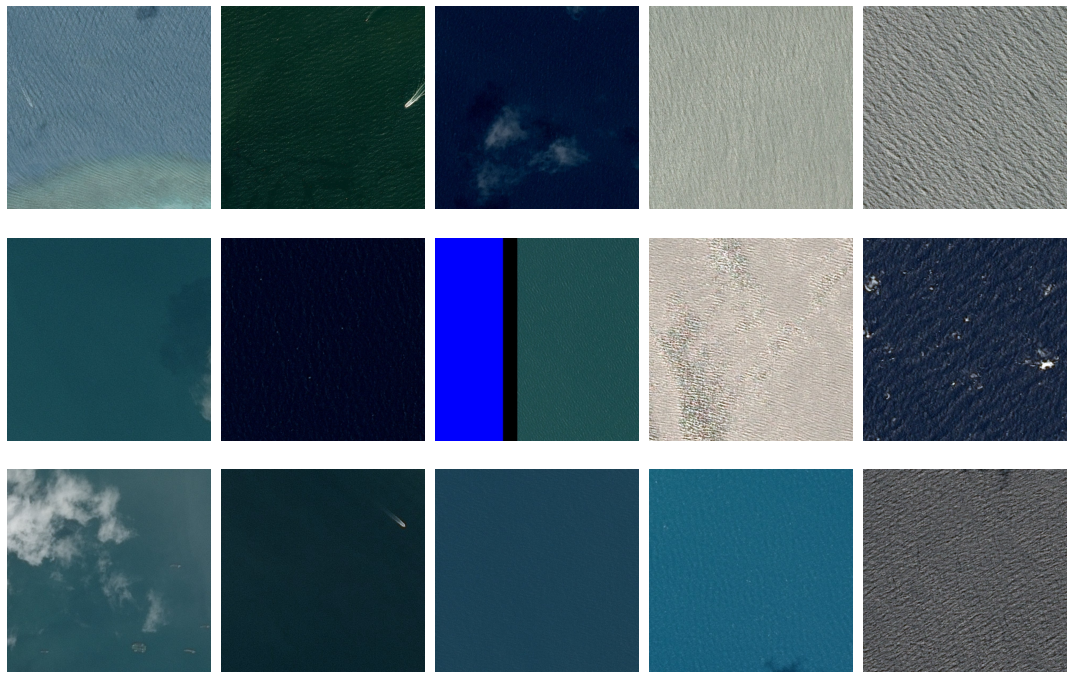

In [3]:
imgs = [f"{TRAIN_PATH}/{f}" for f in sample(os.listdir(TRAIN_PATH), 15)]
fig, axs = plt.subplots(3,5,figsize=(15,10))
for ax, f in zip(axs.flatten(), imgs):
    ax.imshow(plt.imread(f))
    ax.axis("off")
plt.tight_layout()
plt.show()

All images are sizes 768 x 768

In [7]:
W, H = 768,768

In [5]:
df = pd.read_csv(LABELS_PATH)
len(df), len(os.listdir(TRAIN_PATH))

(231723, 192556)

We can see that there are more entries in the df that images in the training data.

That is because in the .csv there are multiple entries for images with more than 1 ship).

Let's gather all ships on each image into one place.

In [6]:
data = dict()
for i in df.values:
    if i[0] not in data:
        data[i[0]] = dict()
    if isinstance(i[1], str): # if there is a ship and not a NaN
        data[i[0]][len(data[i[0]])] = list(map(int, i[1].split()))
imgs = list(data.keys())

In [7]:
with open("./jsons/train_data_v2.json", "w") as f:
    json.dump(data, f) # will need this for training

In [3]:
with open("./jsons/train_data_v2.json", "r") as f:
    data = json.load(f) # will need this for training
images = list(data.keys())

The detected ship mask is in run-length format.

We need to be able to convert it into an actual mask.

In [4]:
def ships_to_mask(ships):
    """
    The run-length format:
    all pixels are numberated as in a flattened image
    (left to right, top to bottom)
    Our data is
        ship_id_1:
            [loc_seq_1, len_seq_1, loc_seq_2, len_seq_2 ...]
        ship_id_2:
            ...
    """
    mask = np.zeros((W*H)) # locations are with respect to a flat mask
    for i in ships:
        for j in range(len(ships[i]) // 2):
            # take all locations and set mask from loc to loc + loc_len to 1
            mask[ships[i][j * 2]:ships[i][j * 2]+ships[i][j * 2+1]] = 1
    mask = mask.reshape((W,H)) # reshape the mask
    return mask

def get_img_and_mask(imgname: str, data: dict) -> (np.array, np.array):
    """
    provide image name
    - reads the image
    - creates a mask
    """
    img = plt.imread(f"{TRAIN_PATH}/{imgname}")
    mask = ships_to_mask(data[imgname])
    return img, mask


Visualize a few images with ships on them

In [8]:
n = 4 # select 4 images
with_ships = []
for i, m in enumerate(images):
    if len(data[m]) > 14: # take images with many ships to see more ships visualized
        with_ships.append(m)
    if len(with_ships) == n:
        break

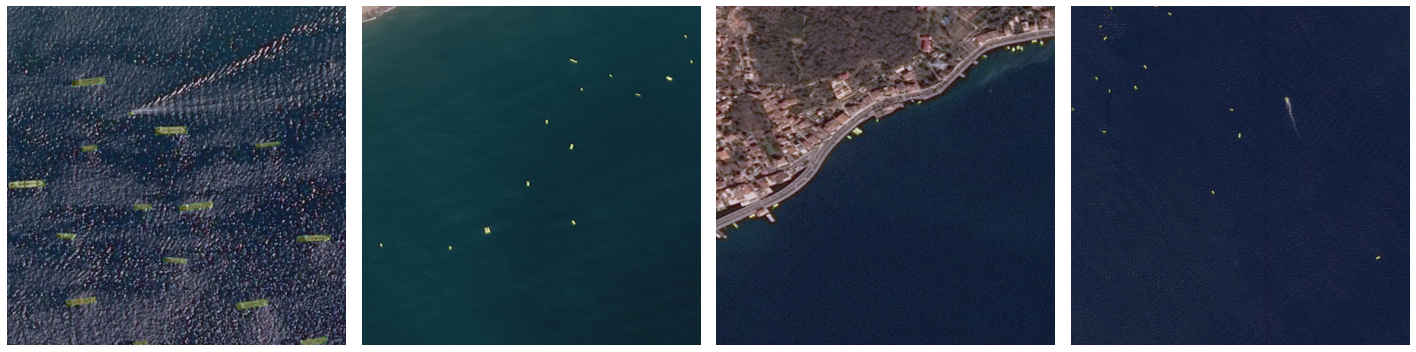

In [9]:
fig, axs = plt.subplots(1,n,figsize=(20,5))
for ax, m in zip(axs.flatten(), with_ships):
    img,mask = get_img_and_mask(m,data)
    ax.imshow(img)
    ax.imshow(mask.T, alpha=0.2)
    ax.axis("off")
    fig.tight_layout()

On the images we can see that ships range from tiny, barely visible to us here (but zoom in and they are there - remember there are 15 ships on each image) to relatively large

We need to find out how much the size of the detected ships varies. This will be important for image segmentation

In [10]:
no_ships = 0 # how many training images don't contain a ship
ships    = 0 # how many ships there are
areas = []   # avg areas of ships on images with ships
for i in images:
    d = data[i] # ships data
    if len(d) > 0: # some ships
        """
        calculate the sizes of all ships
        the run-length representation for each ship is [seq_1_loc, seq_1_len, seq_2_loc, seq_2_len ...]
        sum all "seq_len_"s for each ship detected
        """
        areas +=  [sum([d[i][j*2+1] for j in range(len(d[i])//2)]) for i in d] # areas of ships
        ships += len(d) # count ships
    else: # no ship
        no_ships += 1

In [11]:
no_ships, ships

(150000, 81723)

Make a histogram of number of ships vs area and a histogram of total area of ships with area <= x

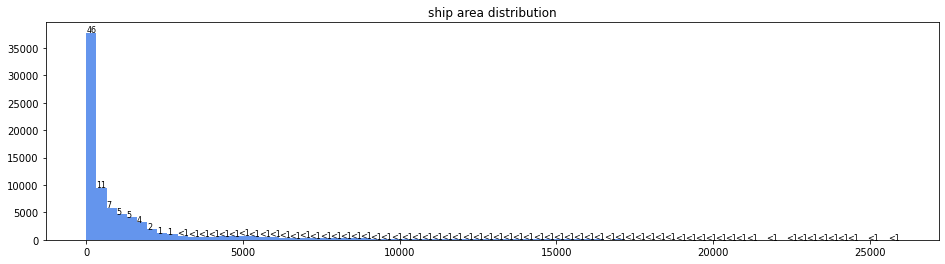

In [12]:
plt.figure(figsize=(16,4))
counts,bins = np.histogram(areas,80)
plt.hist(bins[:-1], bins, weights=counts, color="cornflowerblue")
for c,b in zip(counts,bins[:-1]):
    v = int(c/sum(counts)*100)
    msg = str(v) if v != 0 else "<1"
    if c != 0:
        plt.annotate(msg, (b, c+10), fontsize="8")
plt.title("ship area distribution")
plt.show()

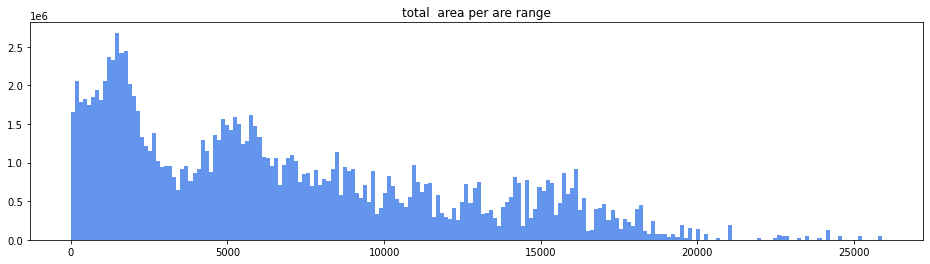

In [13]:
plt.figure(figsize=(16,4))
n,p = plt.hist(areas, bins=200, color="cornflowerblue", weights=areas)[:2]
plt.title("total  area per are range")
plt.show()

In [14]:
len([i for i in areas if i < 4])

13

In [15]:
min(areas), max(areas), np.mean(areas)

(2, 25904, 1567.4028486472596)

We need to precalculate mean for data preprocessing in the network

In [16]:
imgs = os.listdir(r"C:\Users\Diana\Documents\airbus-ship-detection\train_v2")
imgs = imgs[:len(imgs)//2] # will be using the first half of data for training

In [17]:
len(imgs)

96278

In [20]:
means = []
stds = []
img = np.zeros((768,768))
for i, m in enumerate(sample(imgs, len(imgs)//3)): # don't need all images
    try:
        img = plt.imread(f"{TRAIN_PATH}/{m}")
        means.append(img.mean(axis=0).mean(axis=0))
        stds.append(img.std(axis=0).std(axis=0))
    except:
        continue
    if i % 1000 == 0:
        print(f"{i}/{len(imgs)//3}", np.array(means).mean(axis=0), np.array(stds).mean(axis=0), end="\n")
means = np.array(means)
stds = np.array(stds)

0/32092 [22.41252645 47.13542006 59.70107693] [3.8779551  3.19861678 3.04169565]
1000/32092 [53.48997697 73.103694   81.87338424] [4.10395134 3.4593696  3.17384755]
2000/32092 [53.80493199 73.61583576 82.59454772] [4.07674695 3.43005758 3.14717458]
3000/32092 [53.38306677 73.18188882 82.20202606] [4.05732448 3.42249492 3.13061179]
4000/32092 [52.4871753  72.40881061 81.57722583] [3.96217472 3.32960665 3.04258292]
5000/32092 [52.60907922 72.64146717 81.73985926] [3.9695916  3.33302091 3.04367685]
6000/32092 [52.74782927 72.80560785 81.81894907] [3.95585634 3.31943783 3.03412603]
7000/32092 [52.84439334 72.95723041 81.94155488] [3.9705897  3.33358978 3.05197063]
8000/32092 [52.740497   72.93421325 81.930886  ] [3.97940703 3.34368658 3.06138656]
9000/32092 [52.77561463 73.00148636 81.91537086] [3.98066925 3.33799962 3.05279896]
10000/32092 [52.67264464 72.89731834 81.83011005] [4.00236469 3.35632439 3.06860513]
11000/32092 [52.41211098 72.65567029 81.68074804] [4.01329711 3.37480178 3.086

In [21]:
print(means.mean(axis=0))

[51.63868998 71.85261903 81.07552315]


In [22]:
print(stds.mean(axis=0))

[3.92389258 3.31309788 3.03895206]


In [23]:
print(means.mean(axis=0)/255)

[0.20250467 0.28177498 0.31794323]
